# AI-Driven Banknote Demand Forecasting (ANN, National Data)

**Objective**  
Originally prototyped at the Central Bank of the Republic of Türkiye (CBRT) as part of an applied forecasting project.  
This notebook demonstrates monthly demand forecasting for six denominations at the **national** level using artificial neural networks (FNN/MLP, TLNN, LSTM).

**Scope**  
- Neural networks trained on historical demand data (2009–2020).  
- Validation set covering 2021 (12 months).  
- Independent test set covering 2022 (12 months).  
- Part of a broader forecasting framework covering six denominations at both national and regional levels (48 models in total).  
- This notebook focuses on national-level results, as regional datasets are not publicly available.  

**Remarks**  
- Forecast plots include training, validation, and test predictions.  
- Training and validation loss curves illustrate model stability and potential overfitting.  
- Evaluation follows standard time-series conventions (per M4-style validation/test split).
- Evaluation includes error metrics (RMSE, SMAPE, NRMSE) as well as seed robustness indicators (CV, IQR, Δ%) to assess stability.  

**Impact**  
- Achieved accuracies up to 97% (equivalent to SMAPE ≈ 3%) depending on denomination.  
- Delivered actionable insights for strategic banknote management planning.  

> **Note:** All data shown here is demonstration-ready. No institution-specific or confidential information is included.

**Reference**  
Published originally as an official specialization project at the Central Bank of the Republic of Türkiye (Turkish, CBRT archive).   
🔗 [Access the publication](https://bit.ly/CBRT-IshakKutlu-AI-OfficialSpecialization)


## Install Required Packages

In [1]:
'''
!pip install tensorflow
!pip install utils
!pip install autopip
!pip install scikit-learn
!pip install base
!pip install openpyxl
!pip install scikit-learn
!pip install pydot

'''

'\n!pip install tensorflow\n!pip install utils\n!pip install autopip\n!pip install scikit-learn\n!pip install base\n!pip install openpyxl\n!pip install scikit-learn\n!pip install pydot\n\n'

## Import Libraries

In [2]:
## Import Libraries
import os, random
os.environ["TF_DETERMINISTIC_OPS"] = "1"   # deterministic TF ops
os.environ["PYTHONHASHSEED"] = "0"         # stable hashing

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, AlphaDropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math
import datetime
import itertools
import calendar
from numpy.random import seed
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Limit threads for stable timings; reset any leftover graphs
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.keras.backend.clear_session()

import warnings
warnings.filterwarnings("ignore") # cleaner logs

## Data Preparation  
Load 2009–2022 monthly data and keep the first 168 months (14y × 12m).  
Convert denomination columns to float and parse the date column.  
Split into per-denomination frames plus a date series; show head/tail preview.


In [3]:
# Define denomination labels
T200, T100, T50, T20, T10, T5 = "T200", "T100", "T50", "T20", "T10", "T5"
T_Date = "Year"
denomination_list = [T200, T100, T50, T20, T10, T5] # 200 TL, 100 TL, 50 TL, 20 TL, 10 TL, 5 TL

# Load dataset (2009–2022) from Excel
master_df = pd.read_excel('../input/tr-data-2009/Tr_Data_2009.xlsx',
                   names=["Year", "T200", "T100", "T50", "T20", "T10", "T5"],
                   header=0)
master_df = master_df[:168]   # use first 168 months (2009–2022)

# Convert types
master_df[denomination_list] = master_df[denomination_list].astype(float)
master_df[T_Date] = pd.to_datetime(master_df[T_Date])

# Split series by denomination
df200, df100, df50, df20, df10, df5, dfdate = (
    master_df[[T200]], master_df[[T100]], master_df[[T50]], 
    master_df[[T20]], master_df[[T10]], master_df[[T5]], master_df[[T_Date]]
)

pd.concat([master_df.head(12), master_df.tail(12)])

,Year,T200,T100,T50,T20,T10,T5
0,2009-01-01,8876914.0,3.995110e+07,93505642.0,64092306.0,50694248.0,22980385.0
1,2009-02-01,17860948.0,6.300656e+07,139763666.0,90841135.5,78469785.0,39772471.0
2,2009-03-01,21334586.0,8.061803e+07,159515040.5,102041421.5,91379726.0,54386575.0
3,2009-04-01,21311212.0,9.927228e+07,182185537.5,113360739.0,102870382.0,67043738.0
4,2009-05-01,20933523.0,1.064201e+08,185968818.0,116945558.0,106685368.5,74303403.5
5,2009-06-01,21050993.0,1.156620e+08,189705081.0,118271254.5,108725758.0,80488726.0
6,2009-07-01,20895294.0,1.225061e+08,196520892.0,122386182.5,112014302.5,86055826.5
7,2009-08-01,21214158.0,1.295936e+08,197785993.0,122156041.0,113429738.0,90523300.0
8,2009-09-01,22991605.5,1.400615e+08,205815776.5,129304748.5,123787085.5,104414032.0
9,2009-10-01,24770657.0,1.442303e+08,211271346.0,130115468.0,122148389.5,101922905.0


In [4]:
# Data Transformation Utility
# Reshape monthly series into a year-by-month matrix for plotting/evaluation.
def data_transformation(data, dfdate):
    """Reshape a monthly time series into a year×month matrix indexed by Year."""
    
    # Create month labels
    month_list = [calendar.month_abbr[i+1] for i in range(12)]
    df_month = pd.DataFrame(month_list, columns=["Month"])
        
    # Split data into 12-month blocks ([2012-1, 2012-2... 2012-11, 2012-12], ... , [2022-1, 2022-2, ... 2022-11, 2022-12])
    series = data.squeeze()
    year_blocks = []
    for i in range(0, len(series), 12):
        month_block_df = pd.DataFrame(series[i:i+12]).reset_index(drop=True)
        year_blocks.append(month_block_df)
    
    # Combine into matrix format (columns = months, rows = years)
    reshaped_df = pd.concat(year_blocks, axis=1)
    reshaped_df = pd.concat([reshaped_df, df_month], axis=1).set_index("Month")
    reshaped_df = reshaped_df.transpose()
    
    # Extract unique year values
    data = pd.concat([dfdate, data], axis=1)
    data["Year"] = data["Year"].dt.strftime("%Y")
    year_list = [int(data["Year"].iloc[i]) for i in range(0, len(data), 12)]
    
    # Add years to the matrix and set as index
    df_year = pd.DataFrame(year_list, columns=["Year"])
    reshaped_df.reset_index(drop=True, inplace=True)
    reshaped_df = pd.concat([reshaped_df, df_year], axis=1).set_index("Year")
    
    return reshaped_df

## Metrics

In [5]:
def symmetric_mean_absolute_percentage_error(actual, forecast): 
    """Calculate SMAPE (%) between actual and forecast values."""
    actual, forecast = np.array(actual), np.array(forecast)
    smape = np.mean(np.abs((actual - forecast)) / (abs(actual) + abs(forecast))) * 200 # SMAPE (0–200)
    return smape

def root_mean_squared_error(actual, forecast):
    """Calculate RMSE between actual and forecast values."""
    mse = mean_squared_error(actual, forecast)
    rmse = math.sqrt(mse)
    return rmse

def calculate_performance_metrics(actual, forecast):
    """Return SMAPE, RMSE (rounded)."""
    smape = symmetric_mean_absolute_percentage_error(actual, forecast)
    rmse = root_mean_squared_error(actual, forecast)
    return round(smape, 2), round(rmse, 0)

def parameter_combinations(parameters):
    """Generate all combinations of given parameter lists."""
    return list(itertools.product(*parameters))

def reshape_arrays(X_train, y_train):
    """Reshape arrays into model-ready format."""
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

## Model Architecture

In [6]:
# Build and compile a single-layer neural network for univariate regression.
def create_neural_networks(activation, input_nodes, hidden_nodes, output_nodes, l2, dropout, lr):
    """
    Create a single-hidden-layer Keras model for regression.

    Includes L2 regularization and AlphaDropout for stability.
    Returns a compiled Sequential model (MSE loss, Adam optimizer, RMSE metric).
    """
    model = Sequential()
    model.add(Dense(int(hidden_nodes), activation=activation, input_dim=int(input_nodes),
                    kernel_initializer="lecun_normal", kernel_regularizer=regularizers.l2(l2)))
    model.add(AlphaDropout(dropout, seed=42))
    model.add(Dense(int(output_nodes), activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr), metrics=['RootMeanSquaredError'])
    return model

In [7]:
# Build and compile a single-layer LSTM for univariate regression.
def create_LSTM(activation, input_nodes, hidden_nodes, output_nodes, l2, dropout, lr):
    """
    Create a single-layer LSTM model for univariate regression.

    Uses L2 regularization, dropout, and seeded initializers for stability.
    Returns a compiled Sequential model (MSE loss, Adam optimizer, RMSE metric).
    """
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation=activation, recurrent_activation="sigmoid", input_shape=(1, input_nodes), 
                    dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=regularizers.l2(l2), 
                    # recurrent_regularizer=regularizers.l2(1e-5),
                    kernel_initializer=initializers.GlorotUniform(seed=42),
                    recurrent_initializer=initializers.Orthogonal(seed=42),
                    bias_initializer=initializers.Zeros()
                  ))
    model.add(Dropout(dropout, seed=42)) 
    model.add(Dense(output_nodes, activation="linear"))
    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=lr), metrics=["RootMeanSquaredError"])
    return model

## Training, Validation & Test Protocol

In [8]:
# Train (validation: ES+Plateau | test: fixed epochs); return model, train preds, history
MIN_EPOCHS_VALID = 0 # min-epoch guard (0 = disabled)
def train_model(model, X_train, y_train, X_valid, y_valid, epochs, batch_size, 
                es_pat, plat_pat, plat_fac, phase="validation", use_eval_as_val=True):
    """
    Fit in validation (EarlyStopping+LR plateau) or test (fixed epochs) mode.
    Returns (model, train_predictions, history); history may include 'best_epoch_raw', 'min_epoch_guard', 'test_epoch'.
    """

    if phase == "validation" and use_eval_as_val:
        # Early stopping + LR plateau on val_loss (stability for time series)
        early_stopping = EarlyStopping(
            monitor="val_loss",
            min_delta=1e-5,
            patience=es_pat,
            verbose=0,
            mode="auto",
            restore_best_weights=True
        )
        lr_plateau = ReduceLROnPlateau(
            monitor="val_loss",
            mode="auto",
            factor=plat_fac, # reduce LR when val_loss stalls
            patience=plat_pat,
            min_lr=1e-5,
            verbose=0
        )
        
        # Validate on held-out last 12 months (provided as X_valid, y_valid); shuffle=False keeps temporal order
        history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            workers=1, 
            use_multiprocessing=False,
            verbose=0,
            shuffle=False,
            callbacks=[early_stopping, lr_plateau]
        )

        # Record best epoch (1-based) and optionally top up to MIN_EPOCHS_VALID
        valid_loss      = history.history.get("val_loss", [])
        best_epoch_raw  = int(np.argmin(valid_loss)) + 1 
        history.history["best_epoch_raw"]  = int(best_epoch_raw)

        # Minimum-epoch guard: top up training to MIN_EPOCHS_VALID if ES stopped too early
        extra = max(0, MIN_EPOCHS_VALID - best_epoch_raw)
        if extra > 0:
            model.fit(
                X_train, y_train,
                validation_data=(X_valid, y_valid),
                epochs=best_epoch_raw + extra,
                initial_epoch=best_epoch_raw, # continue from best
                batch_size=batch_size,
                workers=1, use_multiprocessing=False,
                verbose=0, shuffle=False,
                callbacks=[]
            )
            history.history["min_epoch_guard"] = True
        else:
            history.history["min_epoch_guard"] = False
        
    elif phase == "test" and use_eval_as_val == False:
        # Final fit (test): fixed-epoch training, ES disabled; report used epochs
        history = model.fit(
            X_train, y_train,
            epochs=epochs, # best_epoch (+buffer) passed in by caller
            batch_size=batch_size,
            workers=1,
            use_multiprocessing=False,
            verbose=0,
            shuffle=False,
            callbacks=[]
        )
        history.history["test_epoch"] = epochs # expose final-fit length
        
    # In-sample predictions (train window)
    train_predict = model.predict(X_train)
    # LSTM safety: flatten 3D outputs to 2D; Dense already returns 2D
    if train_predict.ndim == 3:
        n, t, f = train_predict.shape
        train_predict = train_predict.reshape(n, t * f)
        
    return model, train_predict, history


## Feedforward Neural Network (FNN/MLP)

In [9]:
# Prepare (X, y) windows and the final lags window for forecasting
def preprocess_FNN(data, lags):
    """
    Convert a univariate series into supervised samples using sliding windows.
    Returns (X, y) aligned to lags and the last window for forecasting.
    """
    data = np.array(data)[:, 0]
    X_train, y_train = [], []
    for i in range(data.shape[0]-lags):
        x = data[i:lags+i][::-1]
        y = data[lags+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_forecast = data[i+1:lags+i+1][::-1] # final window for step-ahead forecasts
    input_seq_for_forecast = np.reshape(input_seq_for_forecast, (1, len(input_seq_for_forecast)))
    return X_train, y_train, input_seq_for_forecast

In [10]:
# Iterative forward forecasting with the trained FNN (sliding input window)
def forecast_FNN(model, input_sequence, future_steps):
    """
    Generate forecasts step by step for the next future_steps.
    After each prediction, the new value is added to the front of the window
    and the oldest value is dropped, so the window slides forward.
    Uses recursive forecasting — each prediction feeds into the next window.
    """
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1]) # slide window
    return forecasted_values

## Time-Lagged Neural Network (TLNN)

In [11]:
# Prepare supervised data for TLNN using specified lag points
def preprocess_TLNN(data, lags):
    """
    Build (X, y) for TLNN with explicit lag features.
    Each input row takes values at given lag positions; target is the current value.
    Also returns the last lagged window for forecasting initialization.
    """
    data = np.array(data)[:, 0]
    X_train, y_train = [], []
    for i in range(max(lags), data.shape[0]): 
        x = [data[i - p] for p in lags]
        y = data[i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_forecast = list(data[-max(lags):]) # last window for step-ahead forecasts
    return X_train, y_train, input_seq_for_forecast

In [12]:
# Iterative forward forecasting with TLNN (lag-based input window)
def forecast_TLNN(model, lags, last_sequence, future_steps):
    """
    Generate forecasts step by step for the next future_steps using TLNN.
    Each prediction is based on explicit lag features, then fed back into the sequence
    while dropping the oldest value (recursive forecast).
    """
    forecasted_values = []
    max_lag = max(lags)
    for i in range(future_steps):
        # Build input vector from lagged positions
        input_sequence = [last_sequence[max_lag - p] for p in lags]
        input_sequence = np.asarray(input_sequence).astype('float32')
        # Predict next step and update the sequence
        forecasted_value = model.predict(np.reshape(input_sequence, (1, len(input_sequence))))
        forecasted_values.append(forecasted_value[0][0])
        last_sequence = last_sequence[1:] + [forecasted_value[0][0]]
    return forecasted_values

## Long Short Term Memory (LSTM)

In [13]:
# Prepare (X, y) sequences and the final window for LSTM forecasting
def preprocess_LSTM(data, lags):
    """
    Convert a univariate series into supervised (X, y) samples for LSTM.
    Each sample has length = lags; target is the following value.
    Also returns the last window for forecasting initialization.
    """
    data = np.array(data)[:, 0]
    X_train, y_train = [], []
    for i in range(data.shape[0] - lags):
        x = data[i:lags+i][::-1] # input sequence (lags, reversed)
        y = data[lags+i]
        X_train.append(list(x))
        y_train.append(y)

     # Last lags window -> seed for forecasting (reshape to 3D for LSTM)
    input_seq_for_forecast = data[i+1:lags+i+1][::-1]
    input_seq_for_forecast = np.reshape(input_seq_for_forecast, (1, 1, len(input_seq_for_forecast)))
    return X_train, y_train, input_seq_for_forecast

In [14]:
# Iterative forward forecasting with LSTM (recursive sequence update)
def forecast_LSTM(model, input_sequence, future_steps):
    """
    Generate step-by-step forecasts using the trained LSTM model.
    After each prediction, prepend the new value and drop the oldest one
    (recursive forecast over the specified horizon).
    """
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        # Update sequence: add new forecast, remove last element
        input_sequence[0][0] = np.append(forecasted_value, input_sequence[0][0][:-1])
    return forecasted_values

## Pipeline — End-to-End Forecasting

In [15]:
# Orchestrate end-to-end pipeline
def run_networks(model_type, activation, train_actual, eval_actual, 
                 lags, hidden_nodes, output_nodes, epochs, batch_size, future_steps, 
                 l2, dropout, lr, es_pat, plat_pat, plat_fac,
                 scaler, phase="validation", use_eval_as_val=True):

    """
    End-to-end forecasting pipeline (FNN / TLNN / LSTM).

    Steps
    -----
    1. Scale input data
    2. Convert series into supervised (X, y) windows
    3. For validation: prepend last L training observations as context
    4. Build and train the model
    5. Initialize forecast with the last window from training data
    6. Generate recursive forecasts for the specified 'future_steps'
    7. Inverse-transform results back to original scale

    """

    # Type safety (cast hyperparams)
    if not isinstance(lags, list):
        lags = int(lags)
    hidden_nodes  = int(hidden_nodes)
    output_nodes  = int(output_nodes)
    epochs        = int(epochs)
    batch_size    = int(batch_size)
    future_steps  = int(future_steps)
    l2      = float(l2)
    dropout = float(dropout)
    lr      = float(lr)
    es_pat        = int(es_pat)
    plat_pat      = int(plat_pat)
    plat_fac      = float(plat_fac)
    
    train_actual = train_actual.copy()
    eval_actual = eval_actual.copy()
    
    # Scale and prepare training & evaluation data
    scaled_train_actual = scaler.transform(train_actual)
    scaled_eval_actual = scaler.transform(eval_actual)
    
    # Validation-only: pad eval with last L lags as context
    scaled_ctx_plus_eval = None
    if phase == "validation" and use_eval_as_val: 
        L = lags if isinstance(lags, int) else max(lags)
        ctx = scaled_train_actual[-L:]
        scaled_ctx_plus_eval = np.concatenate([ctx, scaled_eval_actual], axis=0)

    # Prepare train data per model_type
    if model_type == "FNN":
        X_train, y_train, input_seq_for_forecast = preprocess_FNN(scaled_train_actual, lags)
        X_train, y_train = reshape_arrays(X_train, y_train)
    elif model_type == "TLNN":
        X_train, y_train, input_seq_for_forecast = preprocess_TLNN(scaled_train_actual, lags)
        X_train, y_train = reshape_arrays(X_train, y_train)
    elif model_type == "LSTM":
        X_train, y_train, input_seq_for_forecast = preprocess_LSTM(scaled_train_actual, lags)
        X_train = np.reshape(X_train, (len(X_train), 1, lags))
        y_train = np.array(y_train)

    # Prepare validation data per model_type
    if phase == "validation" and use_eval_as_val:
        if model_type == "FNN":
            X_valid, y_valid, _ = preprocess_FNN(scaled_ctx_plus_eval, lags)
            X_valid, y_valid = reshape_arrays(X_valid, y_valid)
        elif model_type == "TLNN":
            X_valid, y_valid, _ = preprocess_TLNN(scaled_ctx_plus_eval, lags)
            X_valid, y_valid = reshape_arrays(X_valid, y_valid)
        elif model_type == "LSTM":
            X_valid, y_valid, _ = preprocess_LSTM(scaled_ctx_plus_eval, lags)
            X_valid = np.reshape(X_valid, (len(X_valid), 1, lags))
            y_valid = np.array(y_valid)
    else:
        # Test phase - no validation
        X_valid, y_valid = None, None

    # Build models
    if model_type == "FNN":
        model = create_neural_networks(
            activation=activation, input_nodes=lags,
            hidden_nodes=hidden_nodes, output_nodes=output_nodes,
            l2=l2, dropout=dropout, lr=lr
        )
    elif model_type == "TLNN":
        model = create_neural_networks(
            activation=activation, input_nodes=len(lags),
            hidden_nodes=hidden_nodes, output_nodes=output_nodes,
            l2=l2, dropout=dropout, lr=lr
        )
    elif model_type == "LSTM":
        model = create_LSTM(
            activation=activation, input_nodes=lags,
            hidden_nodes=hidden_nodes, output_nodes=output_nodes,
            l2=l2, dropout=dropout, lr=lr
        )

    # Training
    model_fit, train_predict, history = train_model(
        model, X_train, y_train, X_valid, y_valid, epochs, batch_size, 
        es_pat, plat_pat, plat_fac, phase=phase, use_eval_as_val=use_eval_as_val
    )

    # Forecast per model_type (recursive)
    if model_type == "FNN":
        eval_predict = forecast_FNN(model_fit, input_seq_for_forecast, future_steps)
    elif model_type == "TLNN":
        eval_predict = forecast_TLNN(model_fit, lags, input_seq_for_forecast, future_steps)
    elif model_type == "LSTM":
        eval_predict = forecast_LSTM(model_fit, input_seq_for_forecast, future_steps)

    # Back to original scale (train & eval outputs)
    train_predict = scaler.inverse_transform(train_predict)
    train_predict = pd.DataFrame(train_predict, index=train_actual.index[-len(train_predict):])
    eval_predict = scaler.inverse_transform(np.array(eval_predict).reshape(-1, 1)).ravel().tolist()

    return eval_predict, train_predict, history

## Visualization — Loss & Forecast

In [16]:
mpl.rcParams.update({"font.size": 11})

# Column index per model for the 3×2 panel; per-denomination panel state
model_col_index = {'FNN': 0, 'TLNN': 1, 'LSTM': 2}
panel_state = {}  # e.g., {'T200': {'fig': fig, 'axes': axes, 'filled': set()}}

def plot_graphs(model_type, T, train_loss, valid_loss, eval_actual, eval_forecast, 
                limiter, train_predict, train_actual, best_epoch, phase="validation"):
    """
    Fill the correct column in a 2×3 panel for the given denomination.
    Columns: FNN | TLNN | LSTM; Rows: Loss | Forecast. Show & clear when all 3 are filled.
    """

    # Color palette
    color_red       = (204/235,  80/235,  85/235)
    color_purple    = (123/235,  85/235, 118/235)
    color_turkois   = ( 26/235, 168/235, 212/235)
    color_blue      = ( 51/235,  94/235, 163/235)
    color_orange    = (221/235, 151/235,  47/235)
    color_gray      = (172/235, 163/235, 150/235)

    # Get or create panel for denomination
    tlabel = str(T)
    if tlabel not in panel_state or panel_state[tlabel].get('fig') is None:
        fig, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=False)
        axes[0, 0].set_title("FNN",  fontsize=12)
        axes[0, 1].set_title("TLNN",  fontsize=12)
        axes[0, 2].set_title("LSTM",  fontsize=12)
        panel_state[tlabel] = {'fig': fig, 'axes': axes, 'filled': set()}

    state = panel_state[tlabel]
    fig, axes = state['fig'], state['axes']
    col = model_col_index[model_type]

    # TOP ROW — training/validation loss
    ax_top = axes[0, col]
    ax_top.plot(train_loss[limiter:], color=color_blue, alpha=1.0, label="Training loss")
    if phase == "validation":
        ax_top.plot(valid_loss[limiter:], color=color_purple, alpha=1.0, label="Validation loss")
    ax_top.axvline(x=best_epoch, color=color_gray, ls="--", lw=1)
    
    if col == 0:
        ax_top.set_ylabel("Standardized Error (MSE)")
    ax_top.set_xlabel("Epoch")
    if col == 2:
        ax_top.legend(loc="upper left", framealpha=0.0)

    # BOTTOM ROW — history fit + actual + forecast
    label_eval = "Actual (valid)" if phase == "validation" else "Actual (test)"
    first_index = eval_actual.index[0]
    ax_bot = axes[1, col]
    ax_bot.plot(train_actual[:len(train_actual)],   color=color_orange,  alpha=1.0, label="Actual (history)")
    ax_bot.plot(train_predict[:len(train_predict)], color=color_turkois, alpha=1.0, label="Model fit (history)")
    ax_bot.plot(eval_actual,                        color=color_red,     alpha=1.0, label=label_eval)
    ax_bot.plot(eval_forecast,                      color=color_blue,    alpha=1.0, label="Forecast")
    ax_bot.axvline(x=first_index,                   color=color_gray, ls="--", lw=1)
    if col == 0:
        ax_bot.set_ylabel("Number of Packages")
    ax_bot.set_xlabel("Date")
    if col == 2:
        ax_bot.legend(loc="upper left", framealpha=0.0)
   
    # Mark this column as filled
    state['filled'].add(col)
    
    # Finalize when all three columns are filled
    if len(state['filled']) == 3:  
        print('\n')
        # Remove per-axes legends; we'll add global legends below
        for r in range(2):
            for c in range(3):
                leg = axes[r, c].get_legend()
                if leg:
                    leg.remove()
    
        # Global title & legends
        h_loss, l_loss = axes[0,0].get_legend_handles_labels()   # 'Train','Validation'
        h_fore, l_fore = axes[1,0].get_legend_handles_labels()   # 'Train','Prediction','Test','Forecasting'
        if phase == "validation":
            fig.suptitle(f"{tlabel} — Training Progress · Forecast vs Actual (Validation · Median Run by RMSE)", y=0.96, fontsize=14)
        else:
            fig.suptitle(f"{tlabel} — Training Progress · Forecast vs Actual (Test · Median Run by RMSE)", y=0.96, fontsize=14)
            
        fig.legend(h_loss, l_loss, ncol=2, loc="lower center",
                   bbox_to_anchor=(0.5, 0.44), frameon=False)
        fig.legend(h_fore, l_fore, ncol=4, loc="lower center",
                   bbox_to_anchor=(0.5, -0.01), frameon=False)
    
        # Layout: leave room for global legends
        fig.tight_layout(rect=[0.0, 0.03, 1, 0.95])
        fig.subplots_adjust(hspace=0.44) 

        plt.show()
        # Reset state for the next denomination
        panel_state[tlabel] = {'fig': None, 'axes': None, 'filled': set()}
        return True
        
    return False

## Evaluation — Grid Search

In [17]:
def get_accuracies(model_type, activation, train_actual, eval_actual, parameters, scaler, seeds, 
                   phase="validation", use_eval_as_val=True):
    """
    Evaluate model variants over parameter combinations and seeds.
    Prints a single horizontal progress line per model (e.g., 'FNN: 1:6 | 2:19 | ...').
    Returns a DataFrame with params, seed, SMAPE/RMSE, horizon forecasts, and artifacts.
    """

    # Expand param grid and align seeds to combinations
    l2, dropout, lr            = float(parameters[-6][0]), float(parameters[-5][0]), float(parameters[-4][0])
    es_pat, plat_pat, plat_fac = int(parameters[-3][0]), int(parameters[-2][0]), float(parameters[-1][0])
    parameters = parameters[:6]
    combination_of_params = parameter_combinations(parameters)
    ncomb = len(combination_of_params) 

    if isinstance(seeds, (int, np.integer)):
        expanded_seeds = [int(seeds)] * ncomb
        combination_of_params_expanded = combination_of_params
        seeds_per_combo = 1
    elif isinstance(seeds, list) and len(seeds) > 0:
        expanded_seeds = [int(s) for _ in range(ncomb) for s in seeds]
        combination_of_params_expanded = [p for p in combination_of_params for _ in range(len(seeds))]
        seeds_per_combo = len(seeds)
    else:
        expanded_seeds = [random.randint(0, 30) for _ in range(ncomb)]
        combination_of_params_expanded = combination_of_params
        seeds_per_combo = 1  # unknown upfront (random each combo)

    # Start a single-line progress for this model (e.g., "FNN: ")
    print(f"{model_type}:", end=" ", flush=True)

    # --------------------------------------------------

    model_information = []

    # Iterate over expanded combinations (params × seeds)
    for i, param in enumerate(combination_of_params_expanded):
        # Unpack combo
        lags, hidden_nodes, output_nodes, epochs, batch_size, future_steps = param

        # Seed per run
        run_seed = expanded_seeds[i]
        try:
            tf.random.set_seed(run_seed)
        except Exception:
            pass

        step = (i % seeds_per_combo) + 1
        if i > 0:
            print(" -> ", end="", flush=True)
        print(f"{step}:{run_seed}", end="", flush=True)
        
        # Run pipeline
        eval_predict, train_predict, history_obj = run_networks(
            model_type, activation, train_actual, eval_actual,
            lags, hidden_nodes, output_nodes, epochs, batch_size, future_steps,
            l2, dropout, lr, es_pat, plat_pat, plat_fac,
            scaler, phase=phase, use_eval_as_val=use_eval_as_val
        )

        # Metrics
        _eval_actual = eval_actual.iloc[:future_steps].to_numpy().flatten()
        smape, rmse = calculate_performance_metrics(_eval_actual, eval_predict)

        # History dict
        hist_dict = getattr(history_obj, "history", {}) if history_obj is not None else {}

        # Row: params + seed + metrics + horizon forecasts + artifacts
        info = list(param) + [run_seed, smape, rmse] + eval_predict + [train_predict, hist_dict]
        model_information.append(info)
    print("\n", flush=True)
    
    # Build the results DataFrame
    model_information_df = pd.DataFrame(model_information)
    horizon_cols = [str(i) for i in range(1, future_steps + 1)]
    model_information_df.columns = [
        'lags', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps',
        'seed', 'SMAPE', 'RMSE'
    ] + horizon_cols + ['train_predict', 'hist_dict']

    return model_information_df


## Reporting — Results & Stability

In [18]:
# Report networks results: print metrics, update globals, and plot curves
model_order = ['FNN','TLNN','LSTM']
report_cache = defaultdict(dict)  # {'T200': {'FNN': {...}, 'TLNN': {...}, 'LSTM': {...}}}

def get_results(model_type, info_df, eval_actual, limiter, train_actual, T,
                phase="validation", use_eval_as_val=True):
    """
    Select the representative run per phase (median-seed if multiple), align horizon,
    compute normalized RMSE (NRMSE), update per-denomination cache, plot the 2×3 panel, and print a compact table.
    Returns nothing; updates `report_cache` and prints when a panel is complete.
    """
    
    # Selection: median-seed (if multiple) else min RMSE
    stab_df = info_df.copy()
    if 'seed' in info_df.columns and info_df['seed'].nunique() > 1:
        med_val  = float(info_df['RMSE'].median())
        best_idx = int((info_df['RMSE'] - med_val).abs().idxmin())
    else:
        best_idx = int(info_df["RMSE"].to_numpy().argmin())

    optimized_params = info_df.loc[best_idx]

    # Align horizon and index
    future_steps = int(optimized_params["future_steps"])
    horizon_cols = [str(i) for i in range(1, future_steps + 1)]
    eval_forecast = optimized_params[horizon_cols]
    eval_actual = eval_actual.iloc[:future_steps]
    eval_forecast.index = eval_actual.index

    # Compute NRMSE (RMSE / mean(eval_actual) * 100)
    eval_mean   = float(np.mean(eval_actual.to_numpy().reshape(-1)))
    rmse_current = float(optimized_params["RMSE"])
    nrmse_pct    = (100.0 * rmse_current / eval_mean) if eval_mean > 0 else np.nan

    # Extract training traces
    train_predict = optimized_params["train_predict"]
    history       = optimized_params["hist_dict"]
    train_loss = history.get("loss", [])
    valid_loss = history.get("val_loss", [])

    # Best epoch (validation) / test epochs
    tlabel = str(T)
    if phase == "validation":
        best_epoch_raw = int(history.get("best_epoch_raw", int(np.argmin(valid_loss)))) # + 1))
        guard_on       = bool(history.get("min_epoch_guard", False))
        best_epoch     = max(best_epoch_raw, MIN_EPOCHS_VALID) if guard_on else best_epoch_raw
    else:
        best_epoch = int(history.get("test_epoch"))
        test_epochs_run = best_epoch
        valid_loss = []
    
    # Plot column; print tables when panel completes
    finished = plot_graphs(
        model_type, T, train_loss, valid_loss,
        eval_actual, eval_forecast, limiter,
        train_predict, train_actual, best_epoch,
        phase=phase
    )

    # Train metrics
    y_true = train_actual.loc[train_predict.index].to_numpy().reshape(-1)
    y_hat  = train_predict.to_numpy().reshape(-1)
    train_SMAPE, train_RMSE = calculate_performance_metrics(y_true, y_hat)

    # Update report cache (validation/test)
    lags_val = optimized_params["lags"]
    if model_type != "TLNN":
        lags_val = int(lags_val)

    # Helper: summarize seed stability (median, CV, IQR%, Δ%)
    def _stability_stats(df):
        if 'seed' not in df.columns or df['seed'].nunique() <= 1:
            return None
        vals = df['RMSE'].to_numpy(dtype=float)
        if len(vals) < 2:
            return None
        mean = float(np.mean(vals)); std = float(np.std(vals, ddof=0))
        cv = 100.0 * (std/mean) if mean > 0 else 0.0
        q1 = float(np.percentile(vals, 25)); q3 = float(np.percentile(vals, 75))
        iqr = q3 - q1
        delta = 100.0 * ((float(np.max(vals)) - float(np.min(vals))) / mean) if mean > 0 else 0.0
        med = float(np.median(vals))
        iqr_pct = (100.0 * iqr / med) if med > 0 else np.nan
        return {"median": med, "cv": cv, "iqr_pct": iqr_pct, "delta": delta}
    
    if phase == "validation":
        # Cache validation results (per model_type) including all seeds
        if 'seed' in stab_df.columns:
            seeds_run_order = stab_df['seed'].astype(int).tolist()
            seed_list = list(dict.fromkeys(seeds_run_order)) 
        else:
            seed_list = [int(optimized_params["seed"])]
    
        report_cache[tlabel][model_type] = {
            "lags": lags_val,
            "hidden": int(optimized_params["hidden_nodes"]),
            "output": int(optimized_params["output_nodes"]),
            "epochs": int(optimized_params["epochs"]),
            "batch": int(optimized_params["batch_size"]),
            "horizon": int(optimized_params["future_steps"]),
            "seed": int(optimized_params["seed"]),
            "seed_list": seed_list,
            "best_epoch": int(best_epoch),
            "train_SMAPE": f"{train_SMAPE:.2f}%",
            "train_RMSE": f"{int(train_RMSE):,}",
            "valid_SMAPE": f"{float(optimized_params['SMAPE']):.2f}%",
            "valid_RMSE": f"{int(optimized_params['RMSE']):,}",
            "valid_stab_stats": _stability_stats(stab_df), # full seed distribution stats
            "valid_NRMSE": ("—" if not np.isfinite(nrmse_pct) else f"{nrmse_pct:.2f}%"),
        }
    else:
        # Cache test results (update only the chosen seed’s stats)
        if tlabel not in report_cache or model_type not in report_cache[tlabel]:
            report_cache[tlabel][model_type] = {}
        report_cache[tlabel][model_type].update({
            "seed": int(optimized_params["seed"]),
            "test_SMAPE": f"{float(optimized_params['SMAPE']):.2f}%",
            "test_RMSE":  f"{int(optimized_params['RMSE']):,}",
            "train_SMAPE": f"{train_SMAPE:.2f}%",
            "train_RMSE":  f"{int(train_RMSE):,}",
            "test_stab_stats": _stability_stats(stab_df), # stability over test runs
            "test_NRMSE": ("—" if not np.isfinite(nrmse_pct) else f"{nrmse_pct:.2f}%"),
            "test_epochs_run": test_epochs_run,  
        })

    # Pretty console table (per phase)
    if finished and phase == "validation":
        line = f"========== RESULTS — {tlabel} (Validation) =========="
        print('\n' + line.center(140) + '\n')

        colw = 30
        header = ["Metric"] + model_order
        print(" | ".join(f"{h:<{colw}}" for h in header))
        print("-" * (len(header) * (colw + 3) - 3))

        rows = [
            ("Best Epoch (Early Stopping)", [report_cache[tlabel][m]["best_epoch"]  for m in model_order]),
            ("Valid RMSE (packages)",       [report_cache[tlabel][m]["valid_RMSE"]  for m in model_order]),
            ("Valid SMAPE (0–200)",         [report_cache[tlabel][m]["valid_SMAPE"] for m in model_order]),
            ("Valid NRMSE (% of mean)",     [report_cache[tlabel][m].get("valid_NRMSE", "—") for m in model_order]),
            ("Seed (median-seed)",          [report_cache[tlabel][m]["seed"]        for m in model_order]),
            ("Median RMSE (seed)", [
                ("—" if not report_cache[tlabel][m].get("valid_stab_stats")
                 else f"{int(round(report_cache[tlabel][m]['valid_stab_stats']['median'])):,}")
                for m in model_order
            ]),
            ("CV (seed, %)", [
                ("—" if not report_cache[tlabel][m].get("valid_stab_stats")
                 else f"{report_cache[tlabel][m]['valid_stab_stats']['cv']:.2f}%")
                for m in model_order
            ]),
            ("IQR% (seed RMSE/median)", [
                ("—" if not report_cache[tlabel][m].get("valid_stab_stats")
                      or not np.isfinite(report_cache[tlabel][m]['valid_stab_stats'].get('iqr_pct', np.nan))
                 else f"{report_cache[tlabel][m]['valid_stab_stats']['iqr_pct']:.2f}%")
                for m in model_order
            ]),
            ("Δ% (seed)", [
                ("—" if not report_cache[tlabel][m].get("valid_stab_stats")
                 else f"{report_cache[tlabel][m]['valid_stab_stats']['delta']:.2f}%")
                for m in model_order
            ]),
        ]
        
        for metric, values in rows:
            print(f"{metric:<{colw}} | " + " | ".join(f"{str(v):<{colw}}" for v in values))
        
        print('\n' + "------------------------------".center(140) + '\n')

    elif finished and phase == "test":
        line = f"========== RESULTS — {tlabel} (Test) =========="
        print('\n' + line.center(140) + '\n')

        colw = 30
        header = ["Metric"] + model_order
        print(" | ".join(f"{h:<{colw}}" for h in header))
        print("-" * (len(header) * (colw + 3) - 3))

        rows = [
            ("Best Epoch (from validation)", [report_cache[tlabel][m]["test_epochs_run"] for m in model_order]), 
            ("Test RMSE (packages)",         [report_cache[tlabel][m]["test_RMSE"]  for m in model_order]),
            ("Test SMAPE (0–200)",           [report_cache[tlabel][m]["test_SMAPE"] for m in model_order]),
            ("Test NRMSE (% of mean)",       [report_cache[tlabel][m].get("test_NRMSE",  "—") for m in model_order]),
            ("Seed (median-seed)",           [report_cache[tlabel][m]["seed"]       for m in model_order]),
            ("Median RMSE (seed)", [
                ("—" if not report_cache[tlabel][m].get("test_stab_stats")
                 else f"{int(round(report_cache[tlabel][m]['test_stab_stats']['median'])):,}")
                for m in model_order
            ]),
            ("CV (seed, %)", [
                ("—" if not report_cache[tlabel][m].get("test_stab_stats")
                 else f"{report_cache[tlabel][m]['test_stab_stats']['cv']:.2f}%")
                for m in model_order
            ]),
            ("IQR% (seed RMSE/median)", [
                ("—" if not report_cache[tlabel][m].get("test_stab_stats")
                      or not np.isfinite(report_cache[tlabel][m]['test_stab_stats'].get('iqr_pct', np.nan))
                 else f"{report_cache[tlabel][m]['test_stab_stats']['iqr_pct']:.2f}%")
                for m in model_order
            ]),
            ("Δ% (seed)", [
                ("—" if not report_cache[tlabel][m].get("test_stab_stats")
                 else f"{report_cache[tlabel][m]['test_stab_stats']['delta']:.2f}%")
                for m in model_order
            ]),
        ]
        
        for metric, values in rows:
            print(f"{metric:<{colw}} | " + " | ".join(f"{str(v):<{colw}}" for v in values))
        
        print('\n' + "------------------------------".center(140) + '\n')

## Test Configuration

In [19]:
def build_test_config(T, test_actual, parameters):
    """
    Build single-combo test grids and seed lists per model (FNN/TLNN/LSTM) from
    validation-selected settings in `report_cache`. Uses best_epoch with a 1.2× buffer
    and sets test horizon = len(test_actual). Returns (params_test, seeds_test).
    """
    
    # Unpack validation-time parameter templates (to copy hparams tail: l2, dropout, lr, es, plateau)
    fnn_params, tlnn_params, lstm_params = parameters

    # FNN hyperparams
    l2_fnn, dropout_fnn, lr_fnn, es_fnn, ppat_fnn, pfac_fnn = (
        float(fnn_params[-6][0]), float(fnn_params[-5][0]), float(fnn_params[-4][0]),
        int(fnn_params[-3][0]),   int(fnn_params[-2][0]),   float(fnn_params[-1][0])
    )
    # TLNN hyperparams
    l2_tlnn, dropout_tlnn, lr_tlnn, es_tlnn, ppat_tlnn, pfac_tlnn = (
        float(tlnn_params[-6][0]), float(tlnn_params[-5][0]), float(tlnn_params[-4][0]),
        int(tlnn_params[-3][0]),   int(tlnn_params[-2][0]),   float(tlnn_params[-1][0])
    )
    # LSTM hyperparams
    l2_lstm, dropout_lstm, lr_lstm, es_lstm, ppat_lstm, pfac_lstm = (
        float(lstm_params[-6][0]), float(lstm_params[-5][0]), float(lstm_params[-4][0]),
        int(lstm_params[-3][0]),   int(lstm_params[-2][0]),   float(lstm_params[-1][0])
    )

    # Extract hyperparams tail per model: [l2, dropout, lr, es_pat, plat_pat, plat_fac]
    # (we read them from the validation grids to keep consistency)
    hparams = {
        'FNN':  (l2_fnn,  dropout_fnn,  lr_fnn,  es_fnn,  ppat_fnn,  pfac_fnn),
        'TLNN': (l2_tlnn, dropout_tlnn, lr_tlnn, es_tlnn, ppat_tlnn, pfac_tlnn),
        'LSTM': (l2_lstm, dropout_lstm, lr_lstm, es_lstm, ppat_lstm, pfac_lstm),
    }

    tlabel = str(T)
    params_test = []
    seeds_test  = []

    for model in ['FNN', 'TLNN', 'LSTM']:
        sel = report_cache[tlabel][model] # populated during validation
        # Lags block: keep TLNN as nested list ([[...]]), FNN/LSTM as [int]
        lags_block = [sel['lags']]
        # Epoch policy: start from early-stopping best_epoch, add 20% buffer for test
        best_epoch = int(sel['best_epoch'])
        best_epoch_fixed = int(np.ceil(best_epoch * 1.20))
        # Test horizon equals length of the provided test segment
        horizon_test     = len(test_actual)

        # Assemble the 6 core blocks expected by get_accuracies/run_networks
        params = [
            lags_block,                 # lags
            [int(sel['hidden'])],       # hidden_nodes
            [int(sel['output'])],       # output_nodes
            [best_epoch_fixed],         # epochs
            [int(sel['batch'])],        # batch_size
            [horizon_test],             # future_steps
        ]

        # Append hparam tail: [l2], [dropout], [lr], [es_pat], [plat_pat], [plat_fac]
        l2_v, do_v, lr_v, es_pat, plat_pat, plat_fac = hparams[model]
        params += [[l2_v], [do_v], [lr_v], [es_pat], [plat_pat], [plat_fac]]

        params_test.append(params)
        
        # Seed policy: prefer the full seed_list captured at validation (for stability check)
        seed_list = report_cache[tlabel][model].get("seed_list", [int(sel['seed'])])
        seeds_test.append(seed_list)

    return params_test, seeds_test


## Orchestration — Run All Models

In [20]:
def run_system(parameters, seeds, train_actual, eval_actual, limiter, scaler, T, 
               phase="validation", use_eval_as_val=True):
    """
    Run the full evaluation pipeline for FNN, TLNN, and LSTM.
    Dispatches to `get_accuracies` for each model, then aggregates/plots via `get_results`.
    Updates global `report_cache`; returns nothing.
    """
    
    # Phase/flag guard
    if phase == "validation" and use_eval_as_val:
        pass
    elif phase == "test" and use_eval_as_val is False:
        pass
    else:
        raise ValueError(
            "run_system: inconsistent flags. "
            "Use phase='validation' with use_eval_as_val=True, or "
            "phase='test' with use_eval_as_val=False."
        )

    # Model-specific activations (feedforward vs. LSTM)
    activation      = 'selu'
    activation_lstm = 'tanh'

    # Unpack parameter grids, seeds, and plot limiters per model
    fnn_params, tlnn_params, lstm_params = parameters
    fnn_seed, tlnn_seed, lstm_seed = seeds
    fnn_limiter, tlnn_limiter, lstm_limiter = limiter

    # FNN
    information_FNN_df = get_accuracies("FNN", activation, train_actual, eval_actual, 
                                        fnn_params, scaler, fnn_seed, 
                                        phase=phase, use_eval_as_val=use_eval_as_val
                                       )
    get_results("FNN", information_FNN_df, eval_actual, fnn_limiter, train_actual, T, 
                phase=phase, use_eval_as_val=use_eval_as_val
               )
    
    # TLNN
    information_TLNN_df = get_accuracies("TLNN", activation, train_actual, eval_actual, 
                                         tlnn_params, scaler, tlnn_seed, 
                                         phase=phase, use_eval_as_val=use_eval_as_val
                                        )
    get_results("TLNN", information_TLNN_df, eval_actual, tlnn_limiter, train_actual, T, 
                phase=phase, use_eval_as_val=use_eval_as_val
               )

    # LSTM
    information_LSTM_df = get_accuracies("LSTM", activation_lstm, train_actual, eval_actual, 
                                         lstm_params, scaler, lstm_seed, 
                                         phase=phase, use_eval_as_val=use_eval_as_val
                                        )
    get_results("LSTM", information_LSTM_df, eval_actual, lstm_limiter, train_actual, T, 
                phase=phase, use_eval_as_val=use_eval_as_val
               )

## Execution — Validation & Test per Denomination

FNN: 1:6 -> 2:19 -> 3:0 -> 4:4 -> 5:11 -> 6:20 -> 7:14

TLNN: 1:17 -> 2:23 -> 3:15 -> 4:7 -> 5:29 -> 6:16 -> 7:8

LSTM: 1:3 -> 2:29 -> 3:23 -> 4:5 -> 5:6 -> 6:30 -> 7:16





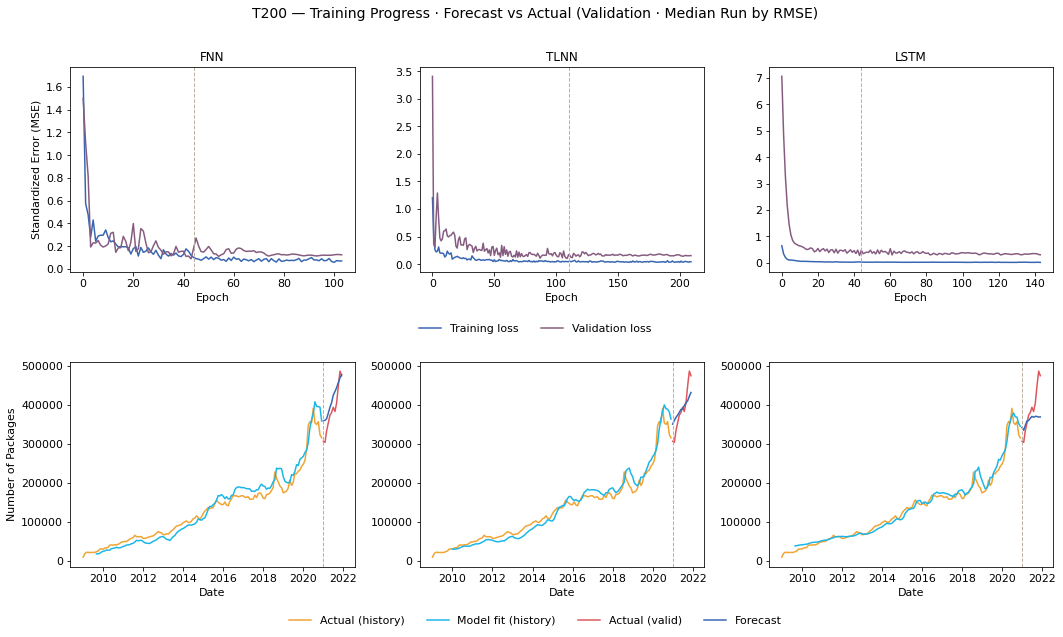


                                             ========== RESULTS — T200 (Validation) ==========                                              

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (Early Stopping)    | 44                             | 110                            | 44                            
Valid RMSE (packages)          | 34,372                         | 34,840                         | 54,766                        
Valid SMAPE (0–200)            | 8.01%                          | 7.29%                          | 10.39%                        
Valid NRMSE (% of mean)        | 8.89%                          | 9.01%                          | 14.17%                        
Seed (median-seed)             | 14                             | 15         

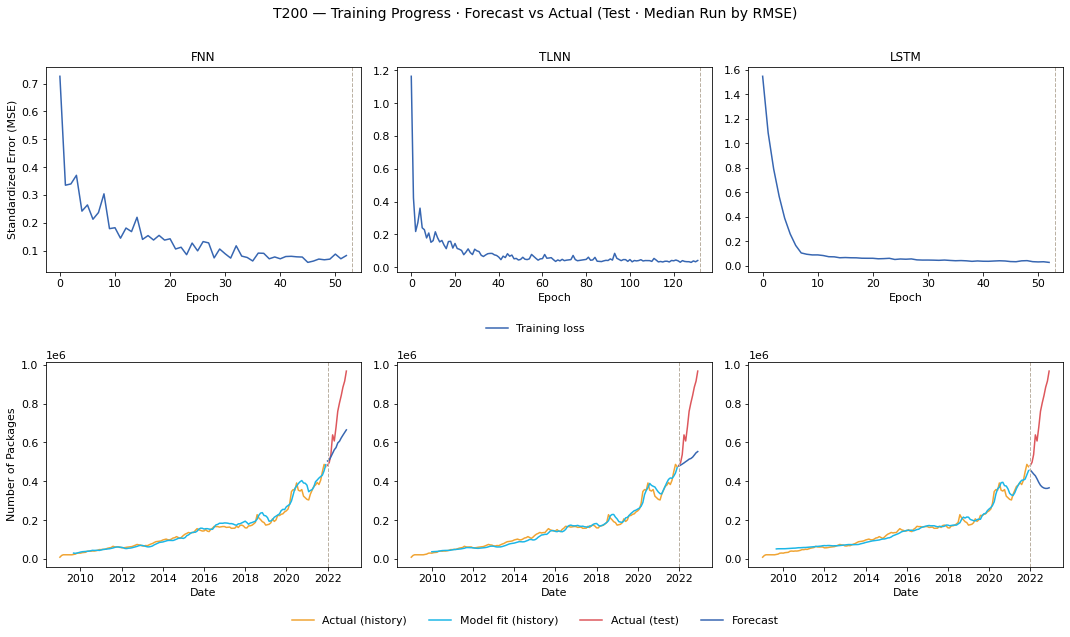


                                                ========== RESULTS — T200 (Test) ==========                                                 

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (from validation)   | 53                             | 132                            | 53                            
Test RMSE (packages)           | 172,871                        | 247,964                        | 373,523                       
Test SMAPE (0–200)             | 19.59%                         | 30.81%                         | 53.91%                        
Test NRMSE (% of mean)         | 24.09%                         | 34.56%                         | 52.05%                        
Seed (median-seed)             | 0                              | 15         

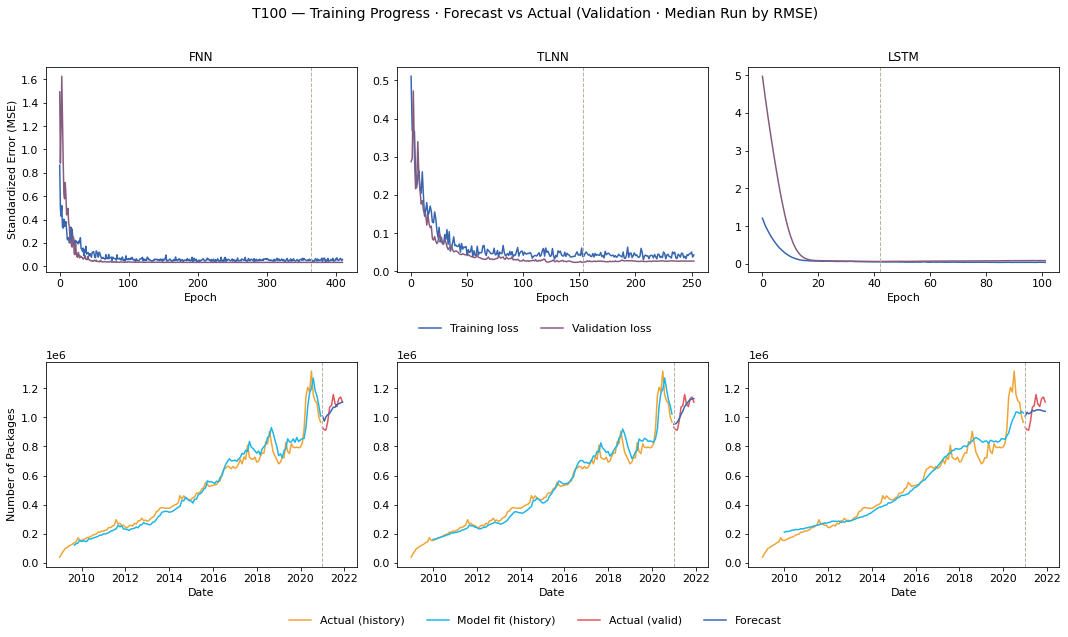


                                             ========== RESULTS — T100 (Validation) ==========                                              

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (Early Stopping)    | 364                            | 153                            | 42                            
Valid RMSE (packages)          | 53,075                         | 38,732                         | 76,804                        
Valid SMAPE (0–200)            | 4.43%                          | 3.07%                          | 6.70%                         
Valid NRMSE (% of mean)        | 5.07%                          | 3.70%                          | 7.33%                         
Seed (median-seed)             | 4                              | 8          

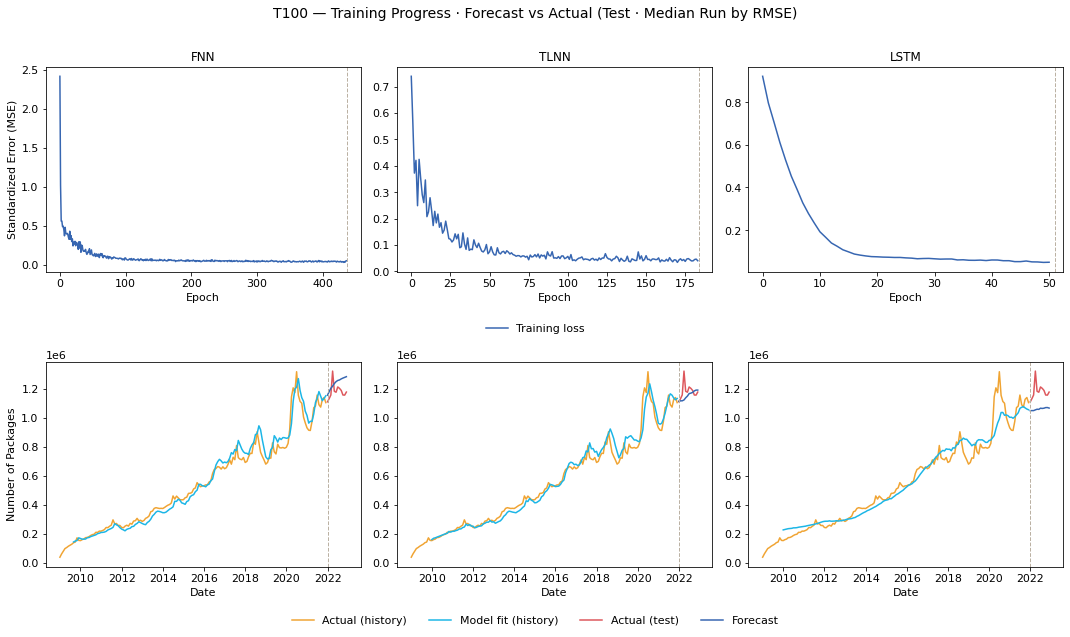


                                                ========== RESULTS — T100 (Test) ==========                                                 

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (from validation)   | 437                            | 184                            | 51                            
Test RMSE (packages)           | 79,976                         | 64,345                         | 130,827                       
Test SMAPE (0–200)             | 6.14%                          | 3.51%                          | 10.70%                        
Test NRMSE (% of mean)         | 6.77%                          | 5.45%                          | 11.08%                        
Seed (median-seed)             | 20                             | 17         

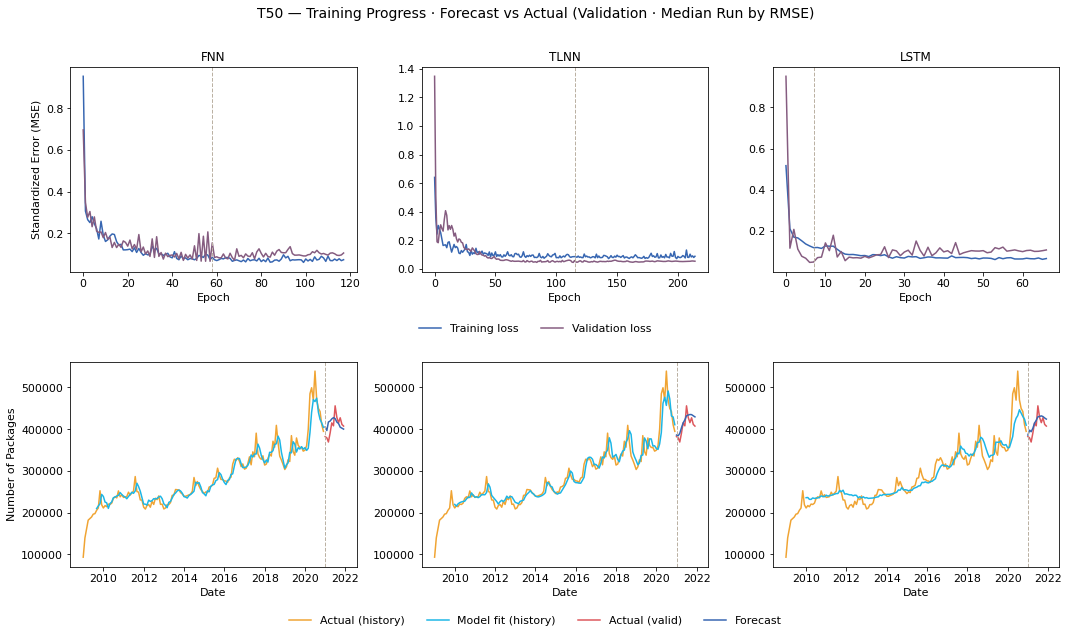


                                              ========== RESULTS — T50 (Validation) ==========                                              

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (Early Stopping)    | 58                             | 115                            | 7                             
Valid RMSE (packages)          | 22,644                         | 15,238                         | 15,157                        
Valid SMAPE (0–200)            | 4.68%                          | 3.14%                          | 3.10%                         
Valid NRMSE (% of mean)        | 5.56%                          | 3.74%                          | 3.72%                         
Seed (median-seed)             | 14                             | 29         

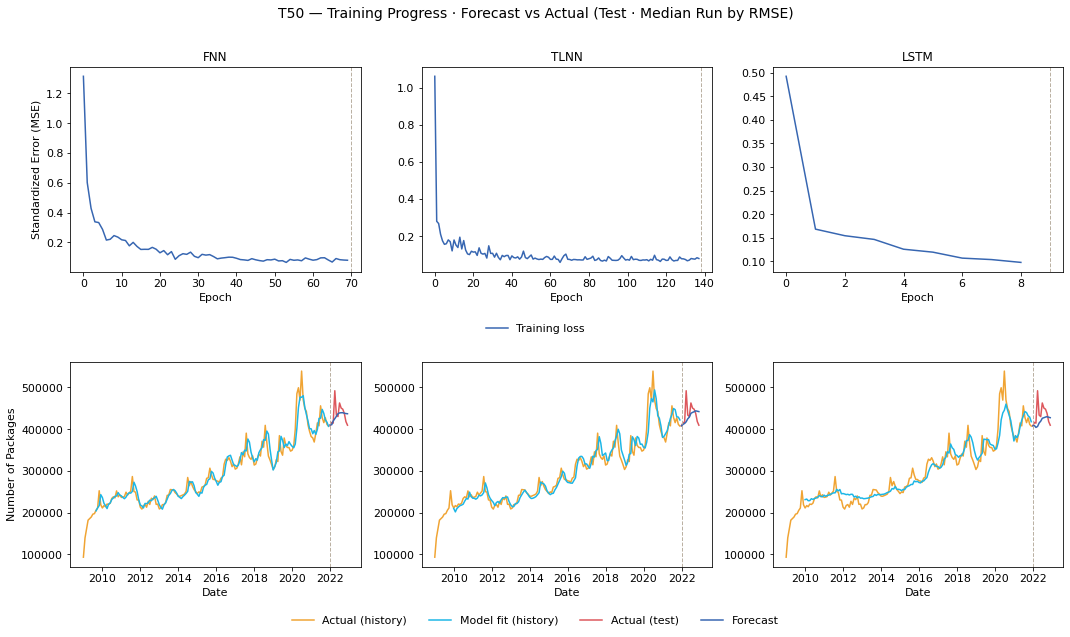


                                                 ========== RESULTS — T50 (Test) ==========                                                 

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (from validation)   | 70                             | 138                            | 9                             
Test RMSE (packages)           | 23,234                         | 25,995                         | 29,842                        
Test SMAPE (0–200)             | 3.39%                          | 3.67%                          | 4.75%                         
Test NRMSE (% of mean)         | 5.34%                          | 5.97%                          | 6.86%                         
Seed (median-seed)             | 20                             | 15         

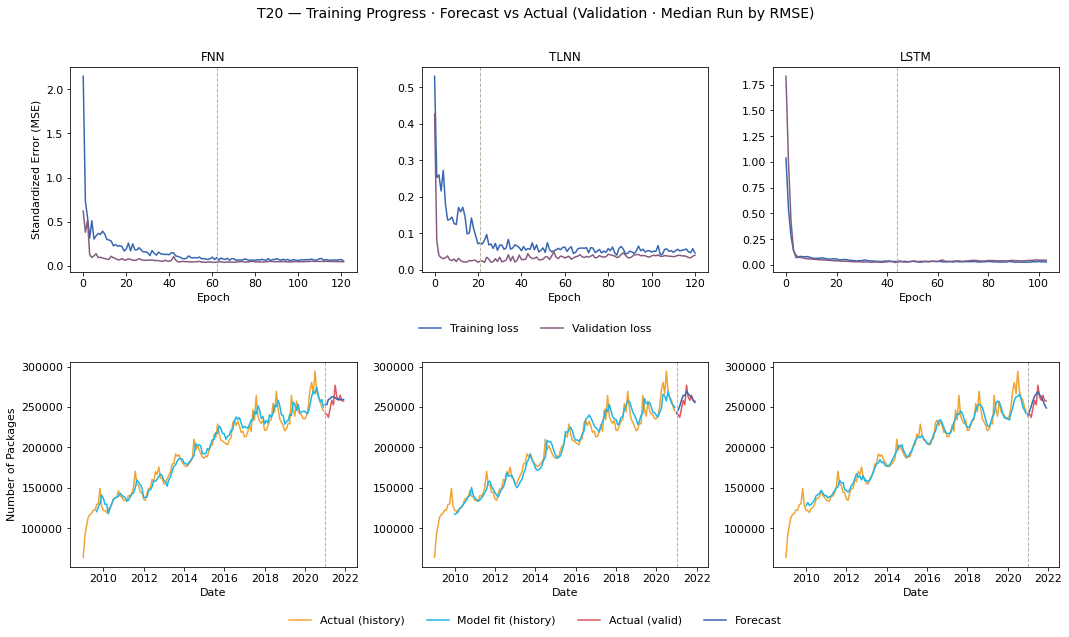


                                              ========== RESULTS — T20 (Validation) ==========                                              

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (Early Stopping)    | 62                             | 21                             | 44                            
Valid RMSE (packages)          | 10,452                         | 7,220                          | 7,864                         
Valid SMAPE (0–200)            | 3.29%                          | 2.29%                          | 2.77%                         
Valid NRMSE (% of mean)        | 4.10%                          | 2.84%                          | 3.09%                         
Seed (median-seed)             | 14                             | 29         

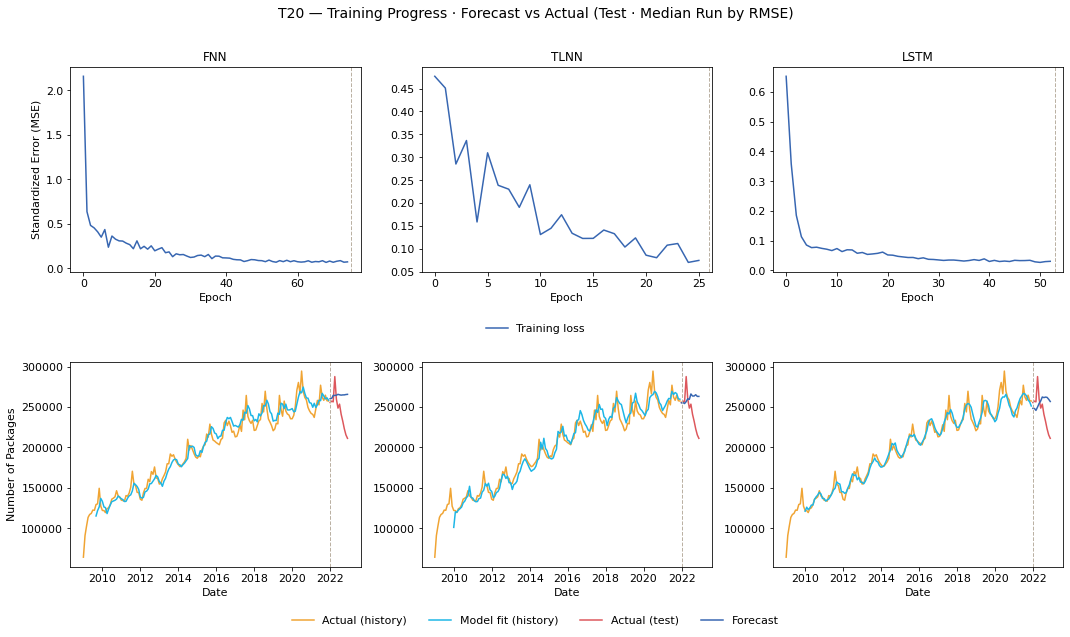


                                                 ========== RESULTS — T20 (Test) ==========                                                 

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (from validation)   | 75                             | 26                             | 53                            
Test RMSE (packages)           | 28,756                         | 28,077                         | 26,928                        
Test SMAPE (0–200)             | 9.23%                          | 8.56%                          | 9.01%                         
Test NRMSE (% of mean)         | 11.73%                         | 11.45%                         | 10.98%                        
Seed (median-seed)             | 14                             | 17         

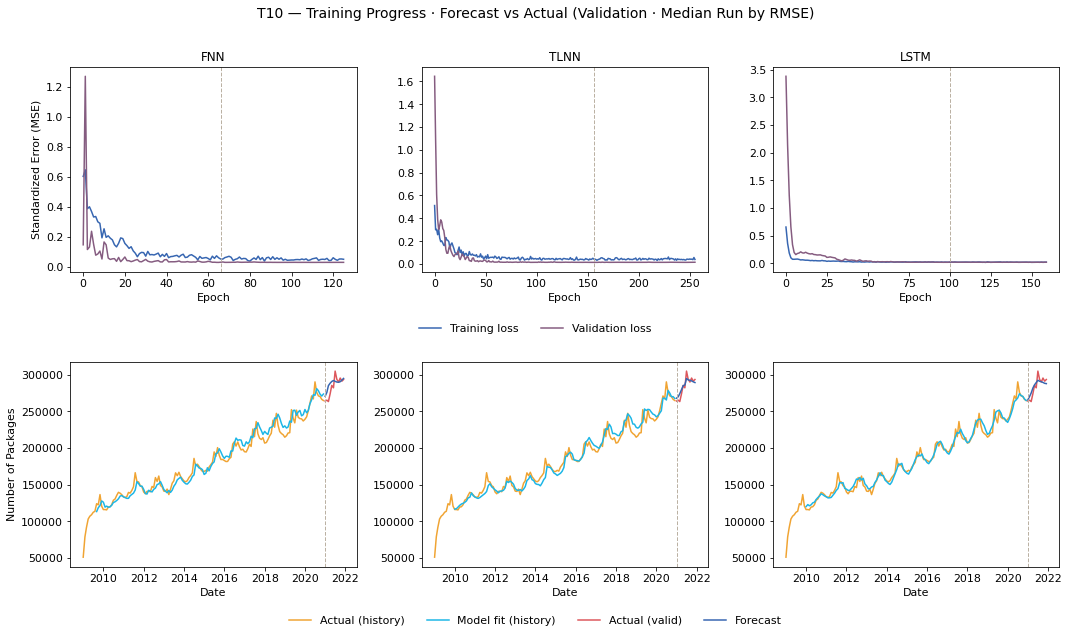


                                              ========== RESULTS — T10 (Validation) ==========                                              

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (Early Stopping)    | 66                             | 156                            | 100                           
Valid RMSE (packages)          | 10,040                         | 5,363                          | 6,570                         
Valid SMAPE (0–200)            | 2.80%                          | 1.53%                          | 1.89%                         
Valid NRMSE (% of mean)        | 3.54%                          | 1.89%                          | 2.32%                         
Seed (median-seed)             | 11                             | 29         

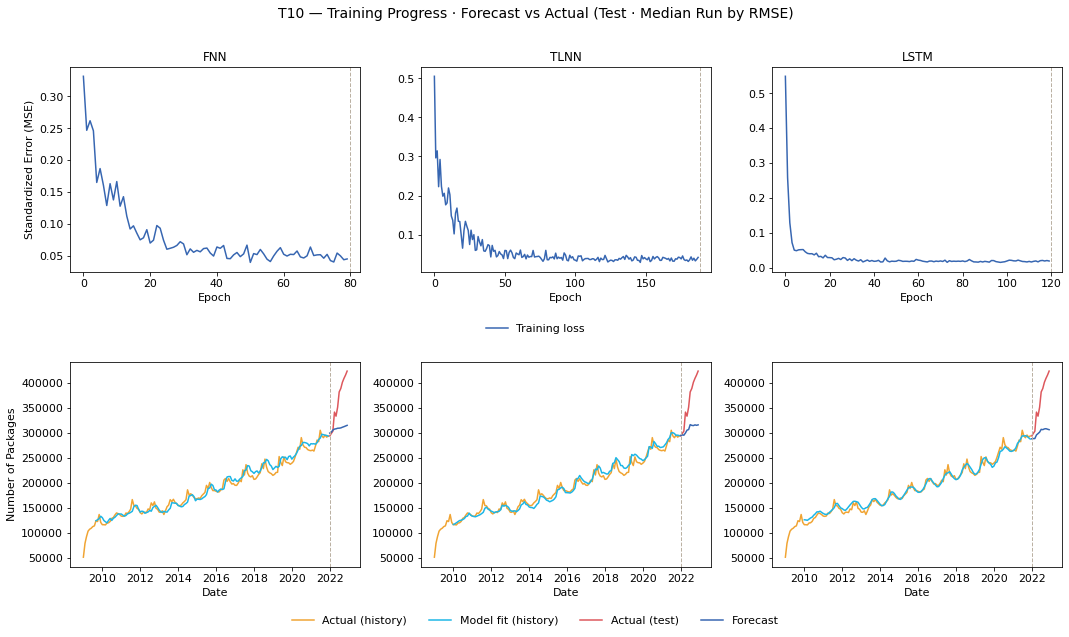


                                                 ========== RESULTS — T10 (Test) ==========                                                 

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (from validation)   | 80                             | 188                            | 120                           
Test RMSE (packages)           | 67,609                         | 66,042                         | 72,494                        
Test SMAPE (0–200)             | 15.66%                         | 15.50%                         | 17.79%                        
Test NRMSE (% of mean)         | 18.69%                         | 18.26%                         | 20.04%                        
Seed (median-seed)             | 19                             | 29         

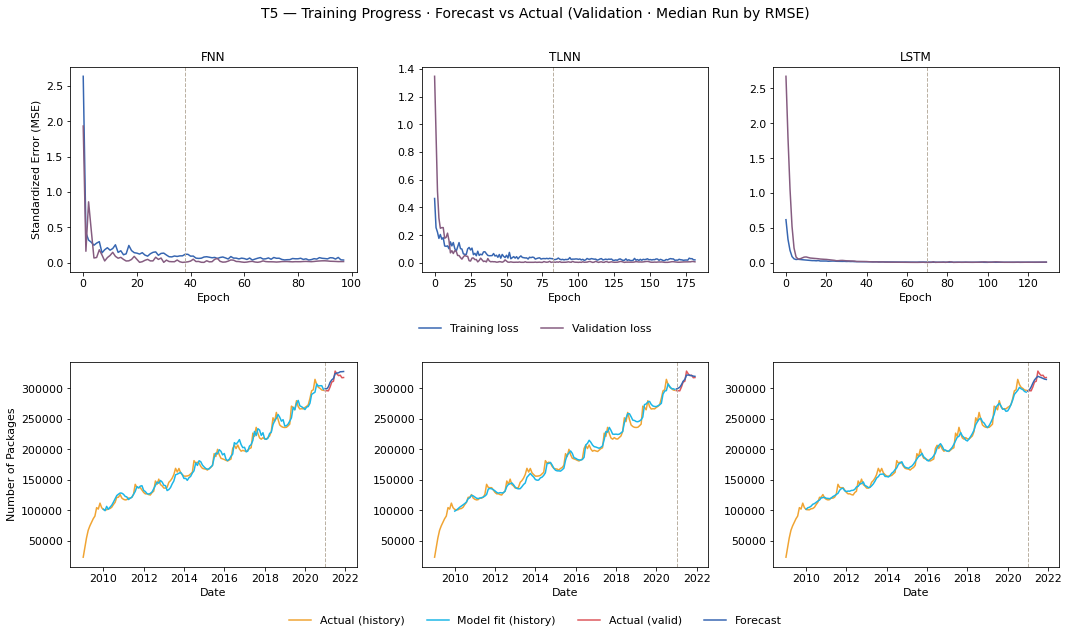


                                              ========== RESULTS — T5 (Validation) ==========                                               

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (Early Stopping)    | 38                             | 82                             | 70                            
Valid RMSE (packages)          | 5,976                          | 3,473                          | 4,817                         
Valid SMAPE (0–200)            | 1.71%                          | 0.95%                          | 1.38%                         
Valid NRMSE (% of mean)        | 1.91%                          | 1.11%                          | 1.54%                         
Seed (median-seed)             | 14                             | 29         

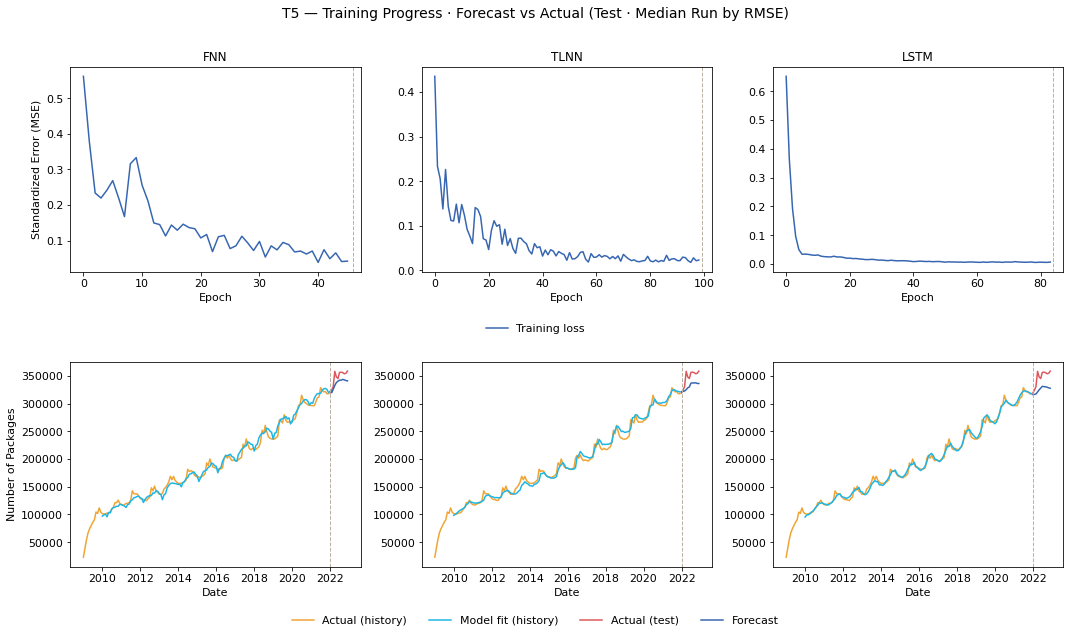


                                                 ========== RESULTS — T5 (Test) ==========                                                  

Metric                         | FNN                            | TLNN                           | LSTM                          
---------------------------------------------------------------------------------------------------------------------------------
Best Epoch (from validation)   | 46                             | 99                             | 84                            
Test RMSE (packages)           | 12,884                         | 18,242                         | 23,582                        
Test SMAPE (0–200)             | 3.27%                          | 4.75%                          | 6.39%                         
Test NRMSE (% of mean)         | 3.72%                          | 5.26%                          | 6.80%                         
Seed (median-seed)             | 4                              | 29         

In [21]:
future_steps = 12 
# denomination_list = [T200, T100, T50, T20, T10, T5] # 200 TL, 100 TL, 50 TL, 20 TL, 10 TL, 5 TL
selected_denomination = None  # None -> run all denominations; e.g. T200 -> run only T200

# Target denominations (single or all)
targets = [selected_denomination] if selected_denomination else denomination_list

for T in targets:
    # Select target series
    df_data = master_df[[T]].copy()
    df_data = (df_data / 1000).round(0)   # Convert to packages (1 package = 1000 banknotes)

    # Transform into Year×Month matrix
    df_matrix = data_transformation(df_data, dfdate).transpose()

    # Generate monthly start dates (from Jan 2009 onwards)
    dates = pd.date_range(start="2009-01", freq="MS", periods=len(df_matrix.columns) * 12)

    # Reshape back into single column and set date index
    np_matrix = df_matrix.transpose().values
    np_matrix = np_matrix.reshape((-1, 1))
    df_data = pd.DataFrame({T: np_matrix[:, 0]}, index=dates)

    # Train/Valid/Test split (2009–2020 = train, 2021 = validation, 2022 = test)
    train_data  = df_data.loc[:'2020'].round(0)
    valid_data  = df_data.loc['2021':'2021'].round(0)
    test_data   = df_data.loc['2022':'2022'].round(0)
    train_valid_data = pd.concat([train_data, valid_data])
        
    # Scaler (fit separately for each denomination)
    scaler_train = StandardScaler().fit(train_data)
    scaler_final = StandardScaler().fit(train_valid_data)

    ###########################################################
    # Notes / examples for seeds & limiter (kept for reference):
    # seeds = [[1], [5], [21]]              # run with selected seed
    # seeds = [[], [], []]                  # run with random seed for model stabilization
    # seeds = [[6, 19, 0, 4, 11, 20, 14, 24, 1],  # FNN
    #         [17, 23, 15, 7, 29, 16, 8, 30, 5],  # TLNN
    #         [3, 29, 23, 5, 6, 30, 16, 8, 21]    # LSTM    
    #         ] 
    # limiter = [0, 0, 0]                   # zoom in train/val loss chart
    
    # Per-denomination hyperparams/seeds (validation phase)
    if T==T200:
        MIN_EPOCHS_VALID = 0 
        # Parameters: lags, hidden, out, epoch, batch,  H,                        l2,   dropout,   lr,   es_pat, plat_pat, plat_fac
        parameters = [
                     [[8], [12], [1], [500], [16], [future_steps],              [1e-4],  [0.05],  [5e-3], [60],  [10], [0.6]],  # FNN
                     [[[1,2,3,6,12]], [16], [1], [500], [12], [future_steps],   [1e-4],  [0.05],  [5e-3], [100], [20], [0.6]],  # TLNN
                     [[8], [10], [1], [500], [16], [future_steps],              [1e-5],  [0.02],  [5e-3], [100], [20], [0.6]]   # LSTM
                     ] 
        seeds = [[6, 19, 0, 4, 11, 20, 14],   # FNN
                 [17, 23, 15, 7, 29, 16, 8],  # TLNN
                 [3, 29, 23, 5, 6, 30, 16]    # LSTM    
                 ]
        # seeds = [[], [], []] 
        limiter = [0, 0, 0] 
        
    elif T==T100:
        MIN_EPOCHS_VALID = 0 
        # Parameters: lags, hidden, out, epoch, batch,  H,                         l2,     dropout,   lr,   es_pat, plat_pat, plat_fac
        parameters = [
                     [[8], [12], [1], [500], [16], [future_steps],                [1e-4],  [0.05],  [3e-3], [60],  [10], [0.6]],  # FNN
                     [[[1,2,3,6,12]], [12], [1], [500], [12], [future_steps],     [1e-4],  [0.05],  [3e-3], [100], [20], [0.7]],  # TLNN
                     [[12], [16], [1], [500], [16], [future_steps],               [1e-5],  [0.01],  [1e-3], [60],  [10], [0.6]]   # LSTM
                     ]
        seeds = [[6, 19, 0, 4, 11, 20, 14],   # FNN
                 [17, 23, 15, 7, 29, 16, 8],  # TLNN
                 [3, 29, 23, 5, 6, 30, 16]    # LSTM    
                 ] 
        # seeds = [[], [], []] 
        limiter = [0, 0, 0] 
        
    elif T==T50:
        MIN_EPOCHS_VALID = 0 
        # Parameters: lags, hidden, out, epoch, batch,  H,                        l2,   dropout,   lr,   es_pat, plat_pat, plat_fac
        parameters = [
                     [[8], [12], [1], [500], [8], [future_steps],                [1e-4],  [0.02],  [5e-3], [60],  [10], [0.6]],  # FNN
                     [[[1,2,3,6,12]], [12], [1], [500], [12], [future_steps],    [1e-4],  [0.02],  [5e-3], [100], [20], [0.6]],  # TLNN
                     [[12], [16], [1], [500], [8], [future_steps],               [5e-4],  [0.03],  [5e-3], [60],  [10], [0.6]]   # LSTM
                     ] 
        seeds = [[6, 19, 0, 4, 11, 20, 14],   # FNN
                 [17, 23, 15, 7, 29, 16, 8],  # TLNN
                 [3, 29, 23, 5, 6, 30, 16]    # LSTM    
                 ] 
        # seeds = [[], [], []]
        limiter = [0, 0, 0] 
        
    elif T==T20:
        MIN_EPOCHS_VALID = 0 
        # Parameters: lags, hidden, out, epoch, batch,  H,                        l2,   dropout,   lr,   es_pat, plat_pat, plat_fac
        parameters = [
                     [[8], [12], [1], [500], [16], [future_steps],              [1e-4],  [0.05],  [5e-3], [60], [10], [0.6]],  # FNN
                     [[[1,2,3,6,12]], [12], [1], [500], [12], [future_steps],   [1e-4],  [0.05],  [5e-3], [100], [20], [0.6]], # TLNN
                     [[12], [16], [1], [500], [16], [future_steps],             [1e-4],  [0.05],  [3e-3], [60], [10], [0.7]]   # LSTM
                     ] 
        seeds = [[6, 19, 0, 4, 11, 20, 14],   # FNN
                 [17, 23, 15, 7, 29, 16, 8],  # TLNN
                 [3, 29, 23, 5, 6, 30, 16]    # LSTM    
                 ] 
        # seeds = [[], [], []]
        limiter = [0, 0, 0] 
        
    elif T==T10:
        MIN_EPOCHS_VALID = 0 
        # Parameters: lags, hidden, out, epoch, batch,  H,                        l2,   dropout,   lr,   es_pat, plat_pat, plat_fac
        parameters = [
                     [[8], [12], [1], [500], [16], [future_steps],              [1e-4],  [0.05],  [5e-3], [60], [10], [0.6]],  # FNN
                     [[[1,2,3,6,12]], [12], [1], [500], [12], [future_steps],   [1e-4],  [0.05],  [3e-3], [100], [20], [0.7]], # TLNN
                     [[12], [16], [1], [500], [16], [future_steps],             [1e-4],  [0.05],  [3e-3], [60], [10], [0.7]]   # LSTM
                     ] 
        seeds = [[6, 19, 0, 4, 11, 20, 14],   # FNN
                 [17, 23, 15, 7, 29, 16, 8],  # TLNN
                 [3, 29, 23, 5, 6, 30, 16]    # LSTM    
                 ] 
        # seeds = [[], [], []]
        limiter = [0, 0, 0] 
        
    elif T==T5:
        MIN_EPOCHS_VALID = 0 
         # Parameters: lags, hidden, out, epoch, batch,  H,                      l2,     dropout,   lr,   es_pat, plat_pat, plat_fac
        parameters = [
                     [[12], [12], [1], [500], [12], [future_steps],             [1e-6],  [0.03],  [3e-3], [60], [10], [0.6]],  # FNN
                     [[[1,2,3,6,12]], [12], [1], [500], [12], [future_steps],   [1e-5],  [0.03],  [3e-3], [100], [20], [0.6]], # TLNN
                     [[12], [16], [1], [500], [16], [future_steps],             [1e-6],  [0.01],  [3e-3], [60], [10], [0.6]]   # LSTM
                     ] 
        seeds = [[6, 19, 0, 4, 11, 20, 14],   # FNN
                 [17, 23, 15, 7, 29, 16, 8],  # TLNN
                 [3, 29, 23, 5, 6, 30, 16]    # LSTM    
                 ] 
        # seeds = [[], [], []]
        limiter = [0, 0, 0]
       
    # Run validation
    run_system(parameters, seeds, train_data, valid_data, limiter, scaler_train , T, 
               phase="validation", use_eval_as_val=True)
    
    # Build single-combo test grids from validation cache
    params_test, seeds_test = build_test_config(T, test_data, parameters)

    # Run test (final fit & evaluation)
    run_system(params_test, seeds_test, train_valid_data, test_data, limiter, scaler_final, T, 
               phase="test", use_eval_as_val=False)